# Perform linear model per CellProfiler feature


## Import libraries


In [1]:
import pathlib
import pandas as pd

from sklearn.linear_model import LinearRegression

from pycytominer.cyto_utils import infer_cp_features


## Set up paths and variables


In [2]:
# Define inputs and outputs
data_dir = pathlib.Path("../3.processing_features/data/single_cell_profiles/")
cp_file = pathlib.Path(data_dir, "Plate_4_sc_normalized.parquet")

output_dir = pathlib.Path("./results")
output_dir.mkdir(exist_ok=True)
output_cp_file = pathlib.Path(output_dir, "linear_model_cp_features_plate4.tsv")


## Read in normalized data


In [3]:
# Load data
cp_df = pd.read_parquet(cp_file)

# Remove rows where Metadata_genotype is "HET" to avoid using in the LM
cp_df = cp_df[cp_df["Metadata_genotype"] != "HET"]

# Define CellProfiler features
cp_features = infer_cp_features(cp_df)

print(f"We are testing {len(cp_features)} CellProfiler features")
print(cp_df.shape)
cp_df.head()


We are testing 2304 CellProfiler features
(7502, 2321)


,Metadata_WellRow,Metadata_WellCol,Metadata_Well,Metadata_Site,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_seed_density,Metadata_siRNA,Metadata_RNAiMax,...,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,B,2,B2,11,115,NF1,WT,1000,None,0,...,-1.015567,-0.991013,-0.427085,-0.492375,-0.505686,-0.492483,3.287944,3.324396,3.234285,3.337852
1,B,2,B2,11,115,NF1,WT,1000,None,0,...,1.254595,1.181604,-0.467826,-0.486035,-0.481063,-0.457716,-0.661907,-0.668559,-0.634783,-0.644279
2,B,2,B2,11,115,NF1,WT,1000,None,0,...,-0.840056,-0.882460,-0.052123,-0.097227,-0.132127,-0.097907,0.252911,0.251474,0.337910,0.296604
3,B,2,B2,11,115,NF1,WT,1000,None,0,...,1.856420,1.740204,0.198178,0.191218,0.173410,0.210927,-0.340967,-0.328878,-0.173260,-0.293306
4,B,2,B2,14,115,NF1,WT,1000,None,0,...,-1.399975,-1.412046,-0.597744,-0.601125,-0.628829,-0.621264,-0.491339,-0.487596,-0.440303,-0.472316


## Set up the dummy matrix between null and WT cell types


In [4]:
# Setup linear modeling framework
variables = ["Metadata_number_of_singlecells"]
X = cp_df.loc[:, variables]

# Add dummy matrix of categorical genotypes, excluding "HET"
genotype_x = pd.get_dummies(data=cp_df.Metadata_genotype)

X = pd.concat([X, genotype_x], axis=1)

print(X.shape)
X.head()


(7502, 3)


,Metadata_number_of_singlecells,Null,WT
0,115,False,True
1,115,False,True
2,115,False,True
3,115,False,True
4,115,False,True


## Perform linear modeling per feature


In [5]:
# Fit linear model for each feature
lm_results = []
for cp_feature in cp_features:
    # Subset CP data to each individual feature (univariate test)
    cp_subset_df = cp_df.loc[:, cp_feature]

    # Fit linear model
    lm = LinearRegression(fit_intercept=True)
    lm_result = lm.fit(X=X, y=cp_subset_df)

    # Extract Beta coefficients
    # (contribution of feature to X covariates)
    coef = lm_result.coef_

    # Estimate fit (R^2)
    r2_score = lm.score(X=X, y=cp_subset_df)

    # Add results to a growing list
    lm_results.append([cp_feature, r2_score] + list(coef))

# Convert results to a pandas DataFrame
lm_results = pd.DataFrame(
    lm_results,
    columns=["feature", "r2_score", "cell_count_coef", "Null_coef", "WT_coef"],
)

# Output file
lm_results.to_csv(output_cp_file, sep="\t", index=False)

print(lm_results.shape)
lm_results.head()


(2304, 5)


,feature,r2_score,cell_count_coef,Null_coef,WT_coef
0,Cytoplasm_AreaShape_Area,0.001685,-0.000522,0.055565,-0.055565
1,Cytoplasm_AreaShape_BoundingBoxArea,0.000344,-0.000431,0.019286,-0.019286
2,Cytoplasm_AreaShape_BoundingBoxMaximum_X,0.000344,0.000728,0.018554,-0.018554
3,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,0.000152,-0.000232,-0.020108,0.020108
4,Cytoplasm_AreaShape_BoundingBoxMinimum_X,0.000517,0.000942,0.015849,-0.015849


## Check to make sure the processing worked


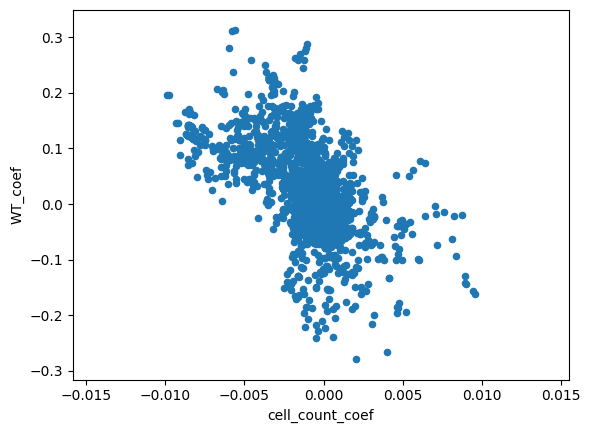

In [6]:
# Small exploration visualization
lm_results.plot(x="cell_count_coef", y="WT_coef", kind="scatter")
